In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras import models,layers
from emnist import list_datasets,extract_test_samples,extract_training_samples
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

list_datasets()

train_images, train_labels = extract_training_samples('balanced')
test_images, test_labels = extract_test_samples('balanced')

In [2]:
# Verileri yeniden şekillendirme
train_images = train_images.squeeze()
train_images = train_images.astype('float32')/255

test_images = test_images.squeeze()
test_images = test_images.astype('float32')/255

num_classes=47

# Etiketleri kategorik hale getirme
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)


In [3]:
# Fourier transformu uygulayan ve özellik çıkarımı yapan fonksiyon
def extract_features(images, parameter):
    features = []
    for img in images:
        # Fourier transformunu uygulama
        f_transform = np.fft.fft2(img)
        f_transform_shifted = np.fft.fftshift(f_transform)
        
        # Belirli bir frekans bandını çıkarmak için bir maske oluşturma
        rows, cols = img.shape
        crow, ccol = rows // 2 , cols // 2
        mask = np.zeros((rows, cols), np.uint8)
        size_row = round(crow*parameter)
        size_col = round(ccol*parameter)
        mask[crow - size_row:crow + size_row, ccol - size_col:ccol + size_col] = 1
        
        # Maskeyi uygulama
        f_transform_shifted_filtered = f_transform_shifted * mask
        
        # Özellik vektörüne dönüştürme
        feature_vector = f_transform_shifted_filtered[crow - size_row:crow + size_row, ccol - size_col:ccol + size_col]
        
        # Magnitüd büyüklük hesaplama
        feature_vector = np.abs(feature_vector)
        feature_vector = feature_vector / np.linalg.norm(feature_vector)

        features.append(feature_vector)
        

    return features

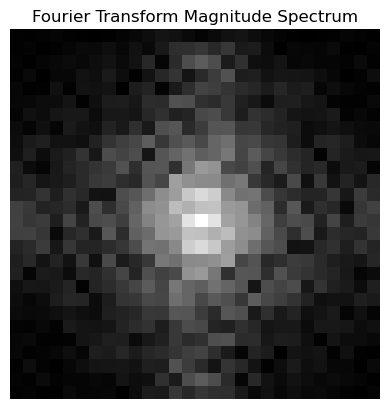

In [4]:
img = train_images[38574]

# Fourier transformunu uygulama
f_transform = np.fft.fft2(img)
f_transform_shifted = np.fft.fftshift(f_transform)

# Fourier transformunun magnitüd spektrumunu kontrol etme
magnitude_spectrum = np.log(np.abs(f_transform_shifted) + 1)
        
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Fourier Transform Magnitude Spectrum')
plt.axis('off')
plt.show()


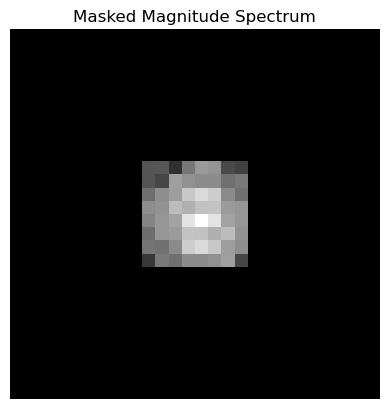

In [5]:
# Belirli bir frekans bandını çıkarmak için bir maske oluşturma
rows, cols = img.shape
crow, ccol = rows // 2 , cols // 2
mask = np.zeros((rows, cols), np.uint8)
parameter = 0.25
size_row = round(crow*parameter)
size_col = round(ccol*parameter)
mask[crow - size_row:crow + size_row, ccol - size_col:ccol + size_col] = 1
        
# Maskeyi uygulama
f_transform_shifted_filtered = f_transform_shifted * mask

# Maskelenmiş magnitüd spektrumunu kontrol etme
magnitude_spectrum_filtered = np.log(np.abs(f_transform_shifted_filtered) + 1)
        
plt.imshow(magnitude_spectrum_filtered, cmap='gray')
plt.title('Masked Magnitude Spectrum')
plt.axis('off')
plt.show()

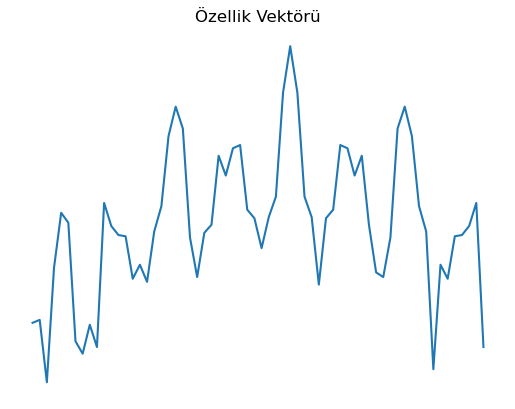

In [6]:
# Özellik vektörüne dönüştürme
f_transform_shifted_filtered_masked = f_transform_shifted_filtered[crow - size_row:crow + size_row, ccol - size_col:ccol + size_col]
feature_vector = np.log(np.abs(f_transform_shifted_filtered_masked) + 1).flatten()
plt.plot(feature_vector)  # özellik vektörünü göster
plt.title('Özellik Vektörü')
plt.axis('off')
plt.show()

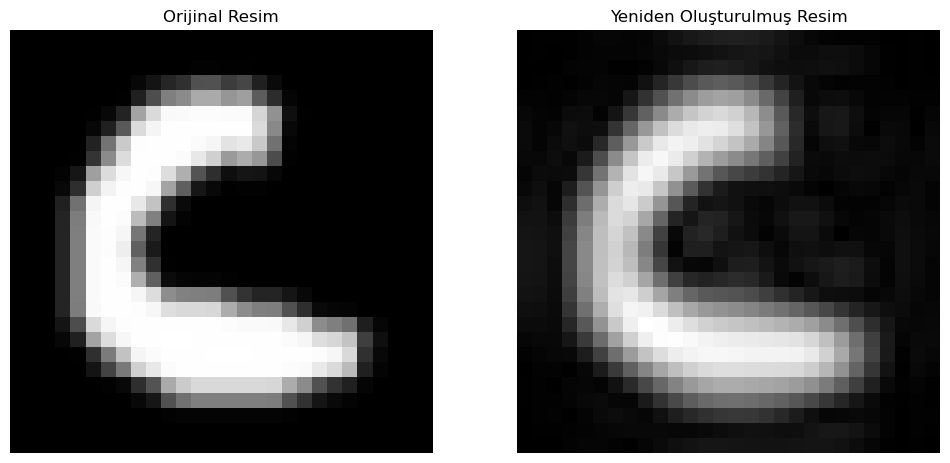

In [7]:
# Çıkarılan özellikleri ve ilk birkaç resmi görselleştirirme
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Orijinal Resim')
plt.axis('off')
       
# Ters Fourier transformunu uygulama
f_transform_shifted = np.fft.ifftshift(f_transform_shifted_filtered)
reconstructed_img = np.fft.ifft2(f_transform_shifted)
reconstructed_img = np.abs(reconstructed_img)
    
plt.subplot(1, 2, 2)
plt.imshow(reconstructed_img, cmap='gray') 
plt.title('Yeniden Oluşturulmuş Resim')
plt.axis('off')

plt.show()

In [8]:
features_train = extract_features(train_images, 0.25)
features_test = extract_features(test_images, 0.25)

In [9]:
X_feature_train = np.array(features_train)
X_feature_test = np.array(features_test)

In [22]:
early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)

In [12]:
# fnn modeli oluşturma
fnn_model = Sequential()
fnn_model.add(Flatten(input_shape=X_feature_train[1].shape))
fnn_model.add(Dense(64, activation='relu'))
fnn_model.add(Dropout(0.2))
fnn_model.add(Dense(32, activation='relu'))
fnn_model.add(Dropout(0.2))
fnn_model.add(Dense(16, activation='relu'))
fnn_model.add(Dense(47, activation='softmax'))

opt=Adam(learning_rate=0.001)

fnn_model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

fnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 47)                7

In [13]:
history1 = fnn_model.fit(X_feature_train, train_labels, epochs=100, batch_size=64 ,validation_data=(X_feature_test, test_labels), callbacks=[early_stopping])

Epoch 1/100
1763/1763 [==============================] - 8s 4ms/step - loss: 2.9197 - accuracy: 0.1665 - val_loss: 2.2110 - val_accuracy: 0.3572
Epoch 2/100
1763/1763 [==============================] - 6s 3ms/step - loss: 2.1968 - accuracy: 0.3295 - val_loss: 1.8505 - val_accuracy: 0.4446
Epoch 3/100
1763/1763 [==============================] - 6s 3ms/step - loss: 1.9873 - accuracy: 0.3889 - val_loss: 1.6957 - val_accuracy: 0.4834
Epoch 4/100
1763/1763 [==============================] - 6s 3ms/step - loss: 1.8932 - accuracy: 0.4154 - val_loss: 1.6072 - val_accuracy: 0.5085
Epoch 5/100
1763/1763 [==============================] - 6s 3ms/step - loss: 1.8388 - accuracy: 0.4309 - val_loss: 1.5683 - val_accuracy: 0.5214
Epoch 6/100
1763/1763 [==============================] - 7s 4ms/step - loss: 1.7972 - accuracy: 0.4428 - val_loss: 1.5340 - val_accuracy: 0.5294
Epoch 7/100
1763/1763 [==============================] - 7s 4ms/step - loss: 1.7652 - accuracy: 0.4540 - val_loss: 1.5002 - val_ac

In [14]:
#NN Modeli oluşturma
model = Sequential()
model.add(Flatten(input_shape=(28, 28)))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(47, activation='softmax'))

opt=Adam(learning_rate=0.001)

model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                50240     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 47)               

In [15]:
train_images = np.array(train_images)
test_images = np.array(test_images)

In [17]:
history2 = model.fit(train_images,train_labels, epochs=20, batch_size=64,validation_data=(test_images, test_labels), callbacks=[early_stopping])

Epoch 1/20
1763/1763 [==============================] - 7s 4ms/step - loss: 1.4719 - accuracy: 0.5543 - val_loss: 0.9848 - val_accuracy: 0.7053
Epoch 2/20
1763/1763 [==============================] - 7s 4ms/step - loss: 1.2833 - accuracy: 0.6077 - val_loss: 0.8834 - val_accuracy: 0.7306
Epoch 3/20
1763/1763 [==============================] - 7s 4ms/step - loss: 1.2020 - accuracy: 0.6295 - val_loss: 0.8443 - val_accuracy: 0.7330
Epoch 4/20
1763/1763 [==============================] - 7s 4ms/step - loss: 1.1427 - accuracy: 0.6478 - val_loss: 0.8152 - val_accuracy: 0.7497
Epoch 5/20
1763/1763 [==============================] - 7s 4ms/step - loss: 1.1155 - accuracy: 0.6541 - val_loss: 0.7823 - val_accuracy: 0.7576
Epoch 6/20
1763/1763 [==============================] - 6s 4ms/step - loss: 1.0823 - accuracy: 0.6643 - val_loss: 0.7633 - val_accuracy: 0.7628
Epoch 7/20
1763/1763 [==============================] - 6s 4ms/step - loss: 1.0635 - accuracy: 0.6700 - val_loss: 0.7572 - val_accuracy:

In [18]:
# cnn Modeli oluşturma
cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(16, activation='relu'))
cnn_model.add(Dense(47, activation='softmax'))

opt=Adam(learning_rate=0.001)

cnn_model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 1600)              0         
                                                                 
 dense_8 (Dense)             (None, 64)               

In [28]:
history3 = cnn_model.fit(train_images,train_labels, epochs=3, batch_size=256 ,validation_data=(test_images, test_labels), callbacks=[early_stopping])

Epoch 1/3
441/441 [==============================] - 74s 167ms/step - loss: 0.4728 - accuracy: 0.8380 - val_loss: 0.4115 - val_accuracy: 0.8628
Epoch 2/3
441/441 [==============================] - 79s 179ms/step - loss: 0.4607 - accuracy: 0.8405 - val_loss: 0.4124 - val_accuracy: 0.8665


In [25]:
fnn_loss, fnn_accuracy = fnn_model.evaluate(X_feature_test, test_labels, verbose=0)
cnn_loss, cnn_accuracy = cnn_model.evaluate(test_images, test_labels, verbose=0)
nn_loss, nn_accuracy = model.evaluate(test_images, test_labels, verbose=0)

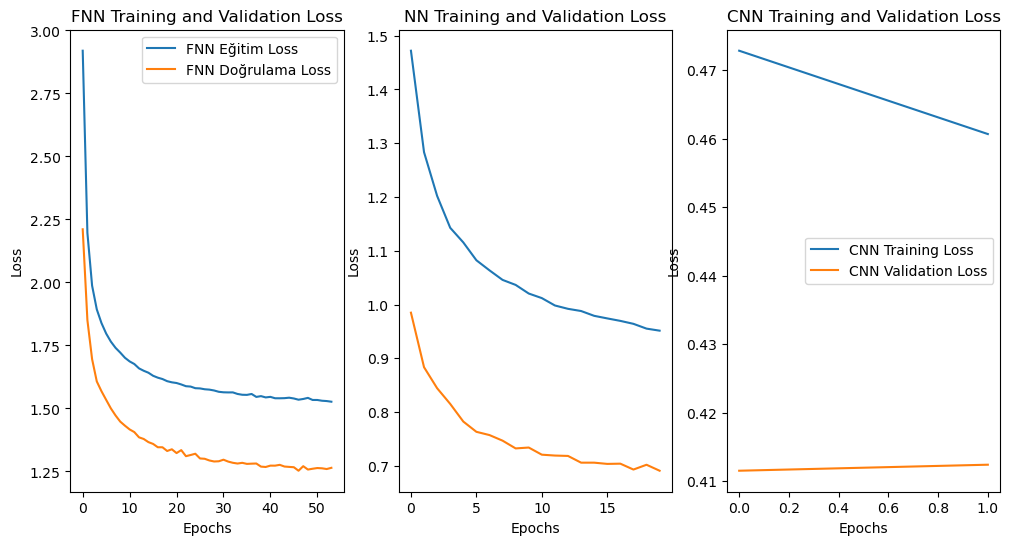

In [33]:
# Eğitim ve Doğrulama Kayıplarını Çizme
plt.figure(figsize=(12, 6))

# FNN Eğitim ve Doğrulama Kayıpları
plt.subplot(1, 3, 1)
plt.plot(history1.history['loss'], label='FNN Eğitim Loss')
plt.plot(history1.history['val_loss'], label='FNN Doğrulama Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('FNN Training and Validation Loss')
plt.legend()

# NN Eğitim ve Doğrulama Kayıpları
plt.subplot(1, 3, 2)
plt.plot(history2.history['loss'], label='NN Training Loss')
plt.plot(history2.history['val_loss'], label='NN Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('NN Training and Validation Loss')

# CNN Eğitim ve Doğrulama Kayıpları
plt.subplot(1, 3, 3)
plt.plot(history3.history['loss'], label='CNN Training Loss')
plt.plot(history3.history['val_loss'], label='CNN Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Training and Validation Loss')
plt.legend()

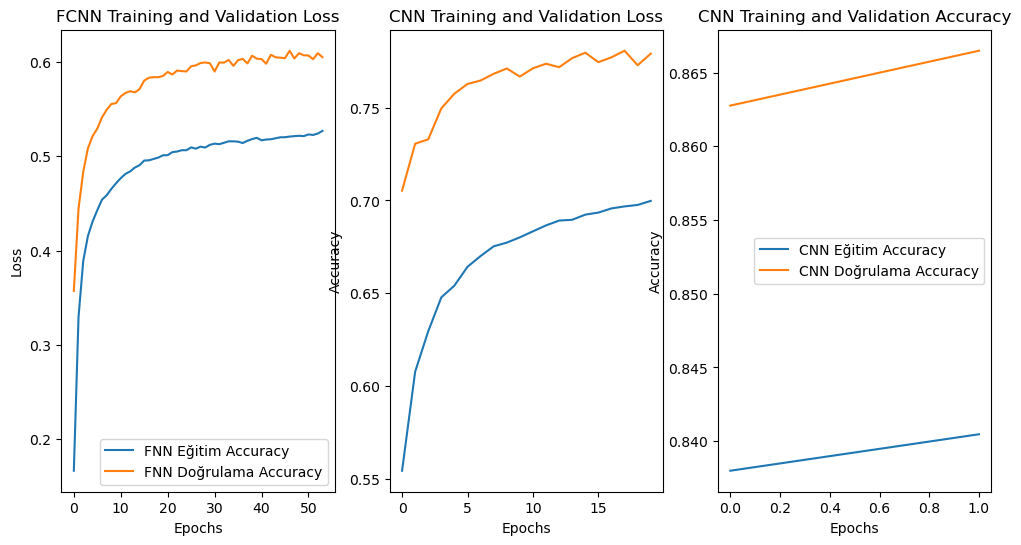

In [34]:
# Eğitim ve Doğrulama Accuracy Çizme
plt.figure(figsize=(12, 6))

# FCNN Eğitim ve Doğrulama Doğruluğu
plt.subplot(1, 3, 1)
plt.plot(history1.history['accuracy'], label='FNN Eğitim Accuracy')
plt.plot(history1.history['val_accuracy'], label='FNN Doğrulama Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('FCNN Training and Validation Loss')
plt.legend()

# NN Eğitim ve Doğrulama Doğruluğu
plt.subplot(1, 3, 2)
plt.plot(history2.history['accuracy'], label='NN Eğitim Accuracy')
plt.plot(history2.history['val_accuracy'], label='NN Doğrulama Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Training and Validation Loss')

# CNN Eğitim ve Doğrulama Doğruluğu
plt.subplot(1, 3, 3)
plt.plot(history3.history['accuracy'], label='CNN Eğitim Accuracy')
plt.plot(history3.history['val_accuracy'], label='CNN Doğrulama Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Training and Validation Accuracy')
plt.legend()